## Sentiment analysis in Finance involves quantifying and exploiting ‘sentiment’ /‘emotions’ for investment.

## 5 Steps of Sentiment Analysis Process for Investment
Conducting Sentiment Analysis involves:
1. Creating a testable hypothesis
2. Extracting relevant data (i.e., a ‘corpus’)
3. Cleaning the text data.
4. Estimating the sentiment measure(s).
5. Testing / validating the hypothesis.

**In this case** testable hypothesis is - 
### Returns of firms with stronger net positive tone are statistically greater compared to the returns of firms with weaker net positive tone.

**H0**: Returns of firms with stronger net positive tone have not statistically greater than the returns of firms with weaker net positive tone.

**H1**: Returns of firms with stronger net positive tone are statistically greater than the returns of firms with weaker net positive tone.

### Relevant Data

Testing this particular hypothesis requires 2 sets of data:

**Returns data (obtained from stock prices)**

**Tone data (obtained by estimating tone/sentiment using words from a corpus)**

## Exploring Stock Price & Returns Data

Here the dataset is a "large" stock price data (daily observations of 99 stocks over approximately 13 years ~ 320,000 observations).


The return on a stock $j$ is calculated as...
$$r_j = \frac{P_t - P_{t-1}}{P_{t-1}} \equiv \frac{P_t}{P_{t-1}}-1$$

Where:  
$r_j = $ Return on a stock $j$ at time $t$  
$P_t = $ Price of stock $j$ at time $t$  
$P_{t-1} = $ Price of stock $j$ at time $t-1$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('data/stock_prices.csv')
df

,ticker,date,price
0,CNP,2005-01-03,8.4000
1,CNP,2005-01-04,8.3168
2,CNP,2005-01-05,8.1662
3,CNP,2005-01-06,8.1730
4,CNP,2005-01-07,8.1277
...,...,...,...
320656,HPQ,2017-11-06,21.4400
320657,HPQ,2017-11-07,21.3800
320658,HPQ,2017-11-08,21.4200
320659,HPQ,2017-11-09,21.3400


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320661 entries, 0 to 320660
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  320661 non-null  object 
 1   date    320661 non-null  object 
 2   price   302651 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB


In [3]:
# conterting date format

df.date=pd.to_datetime(df.date)

In [4]:
# calculating returns for individual firms

df['returns'] = df.groupby('ticker')['price'].pct_change(1)

<AxesSubplot:>

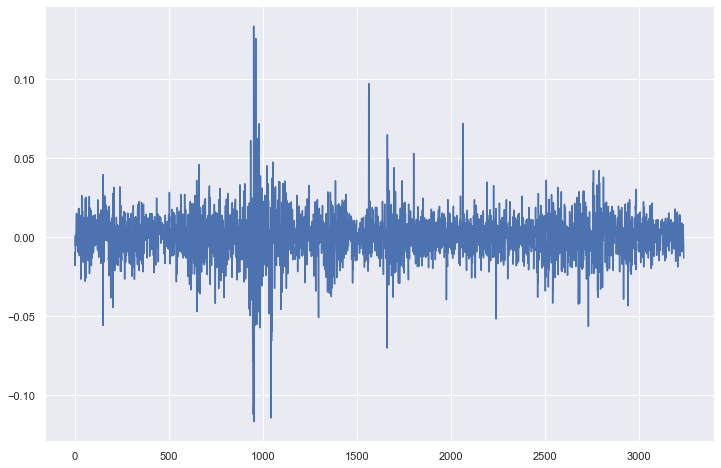

In [9]:
df[df['ticker'] == 'CNP']['returns'].plot(figsize=(12, 8))

<AxesSubplot:>

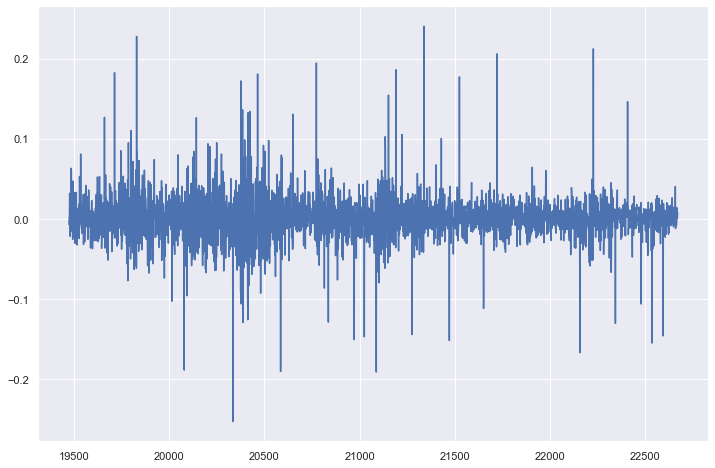

In [10]:
df[df['ticker'] == 'AKAM']['returns'].plot(figsize=(12, 8))

## Find that every firm has giving different return percetages

# Working with text data

## Estimating Sentiment
There are broadly 2 ways of estimating sentiment:

**Lexicon / Dictionary based approach**

**Machine learning approach**

As we do not have a good amount of sentiment data in the domain of Finance (others domain like social media, telecom industry etc have already large amount of data for doing sentiment analysis), I will use Lexicaon based approch here.

Here sentiment is estimated using the proportional counts approach as...
$$\phi_{s_{jt}} = \frac{\sum1_{\mathcal{w}^*_{\mathcal{d}_\mathcal{jt}}\in\psi_s}}{\sum\mathcal{w}^*_{\mathcal{d}_\mathcal{jt}}}$$

Where:  
$\phi_{s_{jt}} = $ $s$ Sentiment estimate for firm $j$ at time $t$  
$\sum1_{\mathcal{w}^*_{\mathcal{d}_\mathcal{jt}}\in\psi_s} = $ Total number of cleaned words in a document of firm $j$ at time $t$ which belong to the sentiment language $s$  
$\sum\mathcal{w}^*_{\mathcal{d}_\mathcal{jt}} = $ Total number of cleaned words in the document for firm $j$ at time $t$

Net Positive Tone can be estimated as...
$$\phi_{NPT} = \frac{\phi_{pos_{jt}} - \phi_{neg_{jt}}}{\phi_{pos_{jt}} + \phi_{neg_{jt}}}$$

In [5]:
import os
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon

In [6]:
# importing text data

MDA_FILES = os.listdir("data/mda/")
MDA_FILES = [file for file in MDA_FILES if file != ".DS_Store"]

In [8]:
# function for cleaning text for analysis

def clean_my_text(mda_file):
    stopwords_nltk = set(stopwords.words('english'))

    with open(mda_file) as file:
        mda_text = file.read()
    
    words = mda_text.split()
    cleaned_words = [word.lower() for word in words if word.isalpha()]
    cleaned_words = [word for word in cleaned_words if word not in stopwords_nltk]
    
    return cleaned_words

In [14]:
# Get positive and negative lexicons / dictionaries from opinion_lexicon

positive_lexicon = set(opinion_lexicon.positive())
negative_lexicon = set(opinion_lexicon.negative())

In [15]:
# Estimate sentiment for all the the firms from the texts


sentiment_scores = {}

for file in MDA_FILES:
    
    cleaned_words = clean_my_text(f"data/mda/{file}")
    positive_sentiment = 0
    negative_sentiment = 0
    
    # Only consider files with more than 100 cleaned words
    if len(cleaned_words) >= 100:
        for word in cleaned_words:
            if word in positive_lexicon:
                positive_sentiment += 1
            elif word in negative_lexicon:
                negative_sentiment += 1
        
        # Estimate sentiment using proportional counts approach
        phi_pos = positive_sentiment / len(cleaned_words)
        phi_neg = negative_sentiment / len(cleaned_words)

        phi_npt = (phi_pos - phi_neg) / (phi_pos + phi_neg)

        sentiment_scores[file] = [phi_pos, phi_neg, phi_npt, len(cleaned_words)]
    
    else: 
        pass


In [16]:
df_scores = pd.DataFrame(sentiment_scores).T
df_scores.reset_index(inplace=True)
df_scores.columns = ['file_name', 'phi_pos', 'phi_neg', 'phi_npt', 'num_cleaned_words']
df_scores

,file_name,phi_pos,phi_neg,phi_npt,num_cleaned_words
0,1001082_MDA_2005-03-16.txt,0.045113,0.041353,0.043478,798.0
1,1001082_MDA_2006-03-15.txt,0.055931,0.045323,0.104762,1037.0
2,1001082_MDA_2007-03-01.txt,0.035032,0.009554,0.571429,314.0
3,1001082_MDA_2008-02-26.txt,0.058747,0.054830,0.034483,766.0
4,1001082_MDA_2009-03-02.txt,0.054920,0.043478,0.116279,437.0
...,...,...,...,...,...
1112,98246_MDA_2015-03-20.txt,0.043050,0.017632,0.418868,4367.0
1113,98246_MDA_2016-03-28.txt,0.038282,0.017489,0.372822,5146.0
1114,98246_MDA_2017-03-17.txt,0.042514,0.017528,0.416149,5363.0
1115,98246_MDA_2018-03-16.txt,0.043184,0.014822,0.488959,5465.0


<AxesSubplot:>

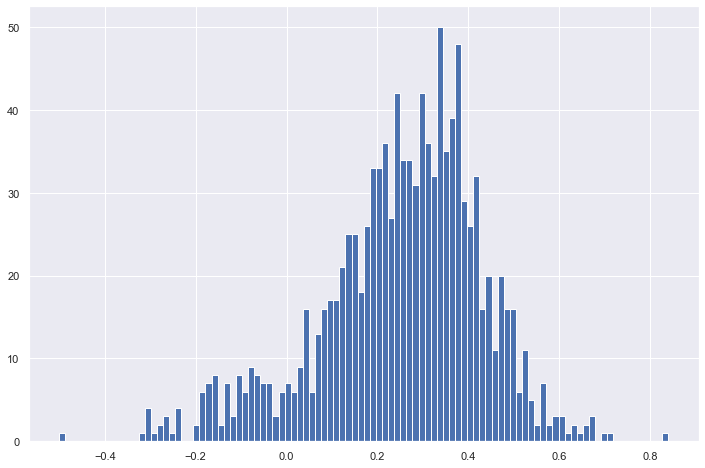

In [17]:
# Explore values of net positive tone across all documents

df_scores['phi_npt'].hist(figsize=(12, 8), bins=100)

#### Found that the Positive tone is lying in the renge from -0.5 to 0.9

### Now time for merging the required data in a single frame for testing the hypostheis

In [19]:
df_returns = pd.read_csv("data/stock_prices_returns.csv")
df_scores = pd.read_csv("data/sentiment_scores.csv")
df_crosswalk = pd.read_csv("data/sp500_constituents.csv")

In [20]:
df_returns.head()

,ticker,date,price,returns
0,CNP,2005-01-03,8.4000,NaN
1,CNP,2005-01-04,8.3168,-0.009905
2,CNP,2005-01-05,8.1662,-0.018108
3,CNP,2005-01-06,8.1730,0.000833
4,CNP,2005-01-07,8.1277,-0.005543


In [21]:
df_scores.head()

,file_name,cik,filing_date,phi_pos,phi_neg,phi_npt,num_cleaned_words
0,1037540_MDA_2017-02-28.txt,1037540,2017-02-28,0.036900,0.040590,-0.047619,271.0
1,26172_MDA_2007-02-27.txt,26172,2007-02-27,0.036629,0.017735,0.347548,8627.0
2,87347_MDA_2015-01-29.txt,87347,2015-01-29,0.045608,0.022545,0.338403,3859.0
3,1087423_MDA_2009-04-29.txt,1087423,2009-04-29,0.035301,0.016278,0.368821,5099.0
4,72741_MDA_2009-02-27.txt,72741,2009-02-27,0.039590,0.016269,0.417512,19424.0


In [22]:
df_crosswalk.head()

,Security,Symbol,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,3M Company,MMM,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902
1,Abbott Laboratories,ABT,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",31/03/1964,1800,1888
2,AbbVie Inc.,ABBV,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",31/12/2012,1551152,2013 (1888)
3,ABIOMED Inc,ABMD,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",31/05/2018,815094,1981
4,Accenture plc,ACN,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",06/07/2011,1467373,1989


In [23]:
df_returns['date'] = pd.to_datetime(df_returns['date'])
df_returns.dropna(subset=['returns'], inplace=True)

In [24]:
df_scores['filing_date'] = pd.to_datetime(df_scores['filing_date'])

In [25]:
df_crosswalk = df_crosswalk[['Symbol', 'CIK']]

In [26]:
# Rename columns to match our existing naming conventions
# This ensures we won't have duplicate columns later on

df_crosswalk.columns = ['ticker', 'cik']

In [27]:
# Merge the returns dataset with the crosswalk using the ticker as a common identifier

df_returns = df_returns.merge(df_crosswalk, on='ticker', how='inner')

In [28]:
df_master = df_returns.merge(df_scores, left_on=['cik', 'date'],right_on=['cik', 'filing_date'],how='left')

In [29]:
# Verifying that it's not ALL missing observations
# Note the number of non-missing tone observations is currently 920

df_master[df_master['phi_npt'].notnull()]

,ticker,date,price,returns,cik,file_name,filing_date,phi_pos,phi_neg,phi_npt,num_cleaned_words
49,CNP,2005-03-16,9.2306,-0.013551,1130310,1130310_MDA_2005-03-16.txt,2005-03-16,0.031456,0.029121,0.038549,7280.0
301,CNP,2006-03-16,9.6470,-0.007714,1130310,1130310_MDA_2006-03-16.txt,2006-03-16,0.033819,0.022748,0.195710,6594.0
540,CNP,2007-02-28,13.5440,-0.001106,1130310,1130310_MDA_2007-02-28.txt,2007-02-28,0.031138,0.021997,0.172043,7001.0
792,CNP,2008-02-28,11.5980,0.001814,1130310,1130310_MDA_2008-02-28.txt,2008-02-28,0.033930,0.022047,0.212276,6985.0
1042,CNP,2009-02-25,7.9907,-0.114447,1130310,1130310_MDA_2009-02-25.txt,2009-02-25,0.034543,0.023719,0.185792,6282.0
...,...,...,...,...,...,...,...,...,...,...,...
301367,HPQ,2012-12-27,5.6096,-0.005778,47217,47217_MDA_2012-12-27.txt,2012-12-27,0.037173,0.028197,0.137324,8689.0
301620,HPQ,2013-12-30,11.4870,-0.004334,47217,47217_MDA_2013-12-30.txt,2013-12-30,0.039027,0.036312,0.036036,8840.0
301865,HPQ,2014-12-18,16.5910,0.030369,47217,47217_MDA_2014-12-18.txt,2014-12-18,0.040528,0.032579,0.108729,8932.0
302115,HPQ,2015-12-16,11.5520,0.004172,47217,47217_MDA_2015-12-16.txt,2015-12-16,0.039710,0.032453,0.100559,9922.0


In [30]:
# Forward fill all missing tone observations

df_master = df_master.groupby('ticker').ffill()

In [31]:
df_master.dropna(inplace=True)

# Estimating Sentiment Portfolio Returns

In [34]:
df_master=df_master.merge(df_crosswalk,on='cik')

In [35]:
df_master

,date,price,returns,cik,file_name,filing_date,phi_pos,phi_neg,phi_npt,num_cleaned_words,ticker
0,2005-03-16,9.2306,-0.013551,1130310,1130310_MDA_2005-03-16.txt,2005-03-16,0.031456,0.029121,0.038549,7280.0,CNP
1,2005-03-17,9.2976,0.007258,1130310,1130310_MDA_2005-03-16.txt,2005-03-16,0.031456,0.029121,0.038549,7280.0,CNP
2,2005-03-18,9.3221,0.002635,1130310,1130310_MDA_2005-03-16.txt,2005-03-16,0.031456,0.029121,0.038549,7280.0,CNP
3,2005-03-21,9.2529,-0.007423,1130310,1130310_MDA_2005-03-16.txt,2005-03-16,0.031456,0.029121,0.038549,7280.0,CNP
4,2005-03-22,8.9938,-0.028002,1130310,1130310_MDA_2005-03-16.txt,2005-03-16,0.031456,0.029121,0.038549,7280.0,CNP
...,...,...,...,...,...,...,...,...,...,...,...
239514,2017-11-06,21.4400,-0.001397,47217,47217_MDA_2016-12-15.txt,2016-12-15,0.041990,0.033725,0.109170,6049.0,HPQ
239515,2017-11-07,21.3800,-0.002799,47217,47217_MDA_2016-12-15.txt,2016-12-15,0.041990,0.033725,0.109170,6049.0,HPQ
239516,2017-11-08,21.4200,0.001871,47217,47217_MDA_2016-12-15.txt,2016-12-15,0.041990,0.033725,0.109170,6049.0,HPQ
239517,2017-11-09,21.3400,-0.003735,47217,47217_MDA_2016-12-15.txt,2016-12-15,0.041990,0.033725,0.109170,6049.0,HPQ


In [36]:
# outlier deletion

# Remove outliers in returns (i.e., those values greater than 3 * standard deviation)

df_master = df_master[abs(df_master['returns']) <= (df_master['returns'].std() * 3)]

### Here I devide the Net Positive Score into five quintiles for doing the analysis.

In [39]:
df_master['quintile_tone_rank'] = pd.qcut(df_master.phi_npt, q=5, labels=['quintile_1','quintile_2','quintile_3','quintile_4','quintile_5'])

<ipython-input-39-97b2ed6039c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master['quintile_tone_rank'] = pd.qcut(df_master.phi_npt, q=5, labels=['quintile_1','quintile_2','quintile_3','quintile_4','quintile_5'])


In [43]:
df_master.groupby('quintile_tone_rank').size()

quintile_tone_rank
quintile_1    48055
quintile_2    47887
quintile_3    48005
quintile_4    47807
quintile_5    47758
dtype: int64

In [44]:
# Estimate returns of equal weighted sentiment portfolios

sentiment_returns = df_master.groupby(['date', 'quintile_tone_rank'])['returns'].mean().unstack()

In [45]:
sentiment_returns

quintile_tone_rank,quintile_1,quintile_2,quintile_3,quintile_4,quintile_5
date,,,,,
2005-02-24,0.024941,NaN,NaN,NaN,NaN
2005-02-25,0.012027,NaN,NaN,NaN,NaN
2005-02-28,-0.005190,NaN,-0.006633,-0.009890,NaN
2005-03-01,0.007290,NaN,0.007021,0.004726,0.019539
2005-03-02,-0.003300,0.004165,0.006649,0.003891,-0.001043
...,...,...,...,...,...
2017-11-06,0.002880,0.011274,0.002556,-0.003245,0.012480
2017-11-07,-0.001627,-0.001145,0.000495,0.000246,-0.013540
2017-11-08,-0.001413,0.000888,0.003861,0.004504,0.008362


In [46]:
# Drop missing observations
sentiment_returns.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

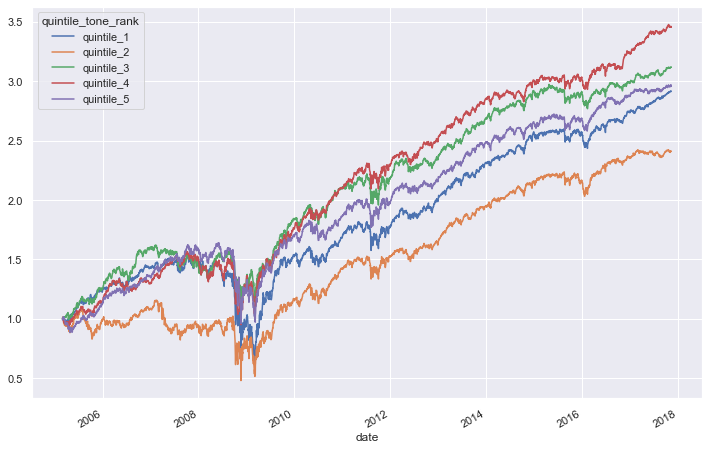

In [47]:
# Plot cumulative returns across all quintiles

(1 + sentiment_returns.cumsum()).plot(figsize=(12, 8))

#### Found that apporx after the year 2008, Quintile_4 has higher positive tone rather than Quintile_5 and Quintile_2 has lowest returns.

# Testing & Validating the Hypothesis

Our hypothesis can be tested and validated by comparing the test-statistic to a critical value (In this case critical value is 2). The t-stat can be estimated by...

$$
tStat = \frac{\overline{x}_{d_{j,k}}}{\hat{\sigma}_{d_{j,k}} \mathbin{/} \sqrt{n}}
$$

Where:  
$\overline{x}_{d_{j,k}} =$ Mean of the difference between the values of group $j$ and $k$  
$\hat{\sigma}_{d_{j,k}} =$ Sample standard deviation of the difference between the values of group $j$ and $k$  
$n = $ Number of observations in the time series

In [48]:
from scipy import stats

In [50]:
# Estimating the tStat

mean_difference = (sentiment_returns['quintile_5'] - sentiment_returns['quintile_1']).mean()
std_difference = (sentiment_returns['quintile_5'] - sentiment_returns['quintile_1']).std()
t_stat = mean_difference / (std_difference / np.sqrt(len(sentiment_returns)))

In [51]:
# Check whether we can reject the null (i.e., if the t_stat >= 2)

t_stat

0.11888488826821002

### So, based on the experiment with this sample, I am unable to reject null hyposthesis i.e. 
**Returns of firms with stronger net positive tone have not statistically greater than the returns of firms with weaker net positive tone.**

While our core hypothesis doesn’t hold, we found some evidence to suggest that firms with stronger Positive tone firms do outperform those with weaker Psotive tone firms, during times of crisis (given a statistically higher return).